In [1]:
# https://github.com/Kaushalya/medclip/blob/master/tools/test_clip.ipynb
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from jax.config import config
config.update("jax_platform_name", "cpu")
import jax
import sys
import numpy as np
import tensorrt
from transformers import AutoTokenizer, CLIPProcessor
from PIL import Image

import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms.functional import InterpolationMode
from torchvision.transforms import Resize, Normalize, ConvertImageDtype, ToTensor

sys.path.append('..')
from medclip.configuration_hybrid_clip import HybridCLIPConfig
from medclip.modeling_hybrid_clip import FlaxHybridCLIP
from medclip.run_medclip import Transform

In [51]:
import flax
import flax.linen as nn
import jax
import jax.numpy as jnp

class FlaxBertModule(nn.Module):
    config: BertConfig
    dtype: jnp.dtype = jnp.float32  # the dtype of the computation
    add_pooling_layer: bool = True

    def setup(self):
        self.embeddings = FlaxBertEmbeddings(self.config, dtype=self.dtype)
        self.encoder = FlaxBertEncoder(self.config, dtype=self.dtype)
        self.pooler = FlaxBertPooler(self.config, dtype=self.dtype)

    def __call__(
        self,
        input_ids,
        attention_mask,
        token_type_ids,
        position_ids,
        deterministic: bool = True,
        output_attentions: bool = False,
        output_hidden_states: bool = False,
        return_dict: bool = True,
    ):
        hidden_states = self.embeddings(
            input_ids, token_type_ids, position_ids, attention_mask, deterministic=deterministic
        )
        outputs = self.encoder(
            hidden_states,
            attention_mask,
            deterministic=deterministic,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        pooled = self.pooler(hidden_states) if self.add_pooling_layer else None

        if not return_dict:
            # if pooled is None, don't return it
            if pooled is None:
                return (hidden_states,) + outputs[1:]
            return (hidden_states, pooled) + outputs[1:]

        return FlaxBaseModelOutputWithPooling(
            last_hidden_state=hidden_states,
            pooler_output=pooled,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱  1 class FlaxBertModule(nn.Module):                                                            │
│    2 │   config: BertConfig                                                                      │
│    3 │   dtype: jnp.dtype = jnp.float32  # the dtype of the computation                          │
│    4 │   add_pooling_layer: bool = True                                                          │
│                                                                                                  │
│ in FlaxBertModule:2                                                                              │
│                                                                                                  │
│    1 class FlaxBertModule(nn.Module):                                                            │
│ ❱  2 │   config: BertConfig                                                                      │
│    3 │   dtype: jnp.dtype = jnp.float32  # the dtype of the computation                          │
│    4 │   add_pooling_layer: bool = True                                                          │
│    5                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'BertConfig' is not defined

In [2]:
from typing import Optional, Tuple

import flax.linen as nn
import jax
import jax.numpy as jnp
from medclip.configuration_hybrid_clip import HybridCLIPConfig
from flax.core.frozen_dict import FrozenDict
from transformers import FLAX_MODEL_MAPPING, FlaxCLIPVisionModel
from transformers.modeling_flax_utils import FlaxPreTrainedModel
from transformers.models.clip.modeling_flax_clip import FlaxCLIPOutput
from transformers.utils import logging


logger = logging.get_logger(__name__)


class FlaxHybridCLIPModule(nn.Module):
    config: HybridCLIPConfig
    dtype: jnp.dtype = jnp.float32
    _do_init: bool = False

    def setup(self):
        text_config = self.config.text_config
        # print(f'text_config={text_config}')
        vision_config = self.config.vision_config

        self.projection_dim = self.config.projection_dim
        self.text_embed_dim = text_config.hidden_size
        self.vision_embed_dim = vision_config.hidden_size

        text_module = FLAX_MODEL_MAPPING[self.config.text_config.__class__].module_class
        print(f'text_module = {text_module}')
        vision_module = FLAX_MODEL_MAPPING.get(self.config.vision_config.__class__, FlaxCLIPVisionModel).module_class

        self.text_model = text_module(text_config, dtype=self.dtype)
        self.vision_model = vision_module(vision_config, dtype=self.dtype)

        self.visual_projection = nn.Dense(
            self.projection_dim,
            dtype=self.dtype,
            kernel_init=jax.nn.initializers.normal(0.02, dtype=self.dtype),
            use_bias=False,
        )
        self.text_projection = nn.Dense(
            self.projection_dim,
            dtype=self.dtype,
            kernel_init=jax.nn.initializers.normal(0.02, dtype=self.dtype),
            use_bias=False,
        )
        self.logit_scale = self.param("logit_scale", jax.nn.initializers.ones, [])
        print(f'self.logit_scale in setup = {self.logit_scale}')

    def __call__(
        self,
        input_ids=None,
        pixel_values=None,
        attention_mask=None,
        position_ids=None,
        token_type_ids=None,
        deterministic: bool = True,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.return_dict

        vision_outputs = self.vision_model(
            pixel_values=pixel_values,
            deterministic=deterministic,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        text_outputs = self.text_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            deterministic=deterministic,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        # print(f'input_ids={input_ids}')
        # print(f'attention_mask={attention_mask}')
        # print(f'token_type_ids={token_type_ids}')
        # print(f'position_ids={position_ids}')
        print(f'input_ids={input_ids.shape}')
        print(f'attention_mask={attention_mask.shape}')
        print(f'token_type_ids={token_type_ids.shape}')
        print(f'position_ids={position_ids.shape}')
        print(f'deterministic={deterministic}')
        print(f'output_attentions={output_attentions}')
        print(f'output_hidden_states={output_hidden_states}')
        print(f'return_dict={return_dict}')

        image_embeds = vision_outputs[1]
        image_embeds = self.visual_projection(image_embeds)
        print(f'text_outputs = {text_outputs}')
        text_embeds = text_outputs[1]
        # print(f'text_embeds1 = {text_embeds}')
        text_embeds = self.text_projection(text_embeds)

        # normalized features
        # print(f'image_embeds = {image_embeds}')
        image_embeds = image_embeds / jnp.linalg.norm(image_embeds, axis=-1, keepdims=True)
        print(f'image_embeds.shape = {image_embeds.shape}')
        # print(f'image_embeds = {image_embeds}')
        # print(f'text_embeds = {text_embeds}')
        # print(f'text_embeds2 = {text_embeds}')
        text_embeds = text_embeds / jnp.linalg.norm(text_embeds, axis=-1, keepdims=True)
        # print(f'text_embeds3 = {text_embeds}')
        print(f'text_embeds.shape = {text_embeds.shape}')
        # print(f'text_embeds = {text_embeds}')

        # cosine similarity as logits
        print(f'self.logit_scale = {self.logit_scale}')
        logit_scale = jnp.exp(self.logit_scale)
        print(f'logit_scale = {logit_scale}')
        
        # print(f'image_embeds = {image_embeds}')
        logits_per_text = jnp.matmul(text_embeds, image_embeds.T) * logit_scale
        print(f'logits_per_text = {logits_per_text}')
        logits_per_image = logits_per_text.T
        print(f'logits_per_image = {logits_per_image}')

        if not return_dict:
            return (logits_per_image, logits_per_text, text_embeds, image_embeds, text_outputs, vision_outputs)

        return FlaxCLIPOutput(
            logits_per_image=logits_per_image,
            logits_per_text=logits_per_text,
            text_embeds=text_embeds,
            image_embeds=image_embeds,
            text_model_output=text_outputs,
            vision_model_output=vision_outputs,
        )


class FlaxHybridCLIP(FlaxPreTrainedModel):
    config_class = HybridCLIPConfig
    module_class = FlaxHybridCLIPModule

    def __init__(
        self,
        config: HybridCLIPConfig,
        input_shape: Optional[Tuple] = None,
        seed: int = 0,
        dtype: jnp.dtype = jnp.float32,
        **kwargs
    ):
        if input_shape is None:
            input_shape = ((1, 1), (1, config.vision_config.image_size, config.vision_config.image_size, 3))

        module = self.module_class(config=config, dtype=dtype, **kwargs)
        super().__init__(config, module, input_shape=input_shape, seed=seed, dtype=dtype)

    def init_weights(self, rng: jax.random.PRNGKey, input_shape: Tuple) -> FrozenDict:
        # init input tensor
        input_ids = jnp.zeros(input_shape[0], dtype="i4")
        position_ids = jnp.broadcast_to(jnp.arange(jnp.atleast_2d(input_ids).shape[-1]), input_shape[0])
        token_type_ids = jnp.ones_like(input_ids)
        attention_mask = jnp.ones_like(input_ids)

        pixel_values = jax.random.normal(rng, input_shape[1])

        params_rng, dropout_rng = jax.random.split(rng)
        rngs = {"params": params_rng, "dropout": dropout_rng}

        return self.module.init(rngs, input_ids, pixel_values, attention_mask, position_ids, token_type_ids)["params"]

    def __call__(
        self,
        input_ids,
        pixel_values,
        attention_mask=None,
        position_ids=None,
        token_type_ids=None,
        params: dict = None,
        dropout_rng: jax.random.PRNGKey = None,
        train: bool = False,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ):
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.return_dict

        if position_ids is None:
            position_ids = jnp.broadcast_to(jnp.arange(jnp.atleast_2d(input_ids).shape[-1]), input_ids.shape)

        if token_type_ids is None:
            token_type_ids = jnp.zeros_like(input_ids)

        if attention_mask is None:
            attention_mask = jnp.ones_like(input_ids)

        # Handle any PRNG if needed
        rngs = {}
        if dropout_rng is not None:
            rngs["dropout"] = dropout_rng

        return self.module.apply(
            {"params": params or self.params},
            jnp.array(input_ids, dtype="i4"),
            jnp.array(pixel_values, dtype=jnp.float32),
            jnp.array(attention_mask, dtype="i4"),
            jnp.array(position_ids, dtype="i4"),
            jnp.array(token_type_ids, dtype="i4"),
            not train,
            output_attentions,
            output_hidden_states,
            return_dict,
            rngs=rngs,
        )

    def get_text_features(
        self,
        input_ids,
        attention_mask=None,
        position_ids=None,
        token_type_ids=None,
        dropout_rng: jax.random.PRNGKey = None,
        train=False,
    ):
        r"""
        Args:
            input_ids (:obj:`numpy.ndarray` of shape :obj:`(batch_size, sequence_length)`):
                Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you
                provide it.

                Indices can be obtained using :class:`~transformers.PreTrainedTokenizer`. See
                :meth:`transformers.PreTrainedTokenizer.encode` and :meth:`transformers.PreTrainedTokenizer.__call__`
                for details.

                `What are input IDs? <../glossary.html#input-ids>`__

        Returns:
            text_features (:obj:`jax_xla.DeviceArray` of shape :obj:`(batch_size, output_dim`): The text embeddings
            obtained by applying the projection layer to the pooled output of text model.
        """
        if position_ids is None:
            position_ids = jnp.broadcast_to(jnp.arange(jnp.atleast_2d(input_ids).shape[-1]), input_ids.shape)

        if token_type_ids is None:
            token_type_ids = jnp.zeros_like(input_ids)

        if attention_mask is None:
            attention_mask = jnp.ones_like(input_ids)

        # Handle any PRNG if needed
        rngs = {}
        if dropout_rng is not None:
            rngs["dropout"] = dropout_rng

        def _get_features(module, input_ids, attention_mask, position_ids, token_type_ids, deterministic):
            text_outputs = module.text_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                position_ids=position_ids,
                token_type_ids=token_type_ids,
                deterministic=deterministic,
            )
            pooled_output = text_outputs[1]
            text_features = module.text_projection(pooled_output)
            return text_features

        return self.module.apply(
            {"params": self.params},
            jnp.array(input_ids, dtype="i4"),
            jnp.array(attention_mask, dtype="i4"),
            jnp.array(position_ids, dtype="i4"),
            jnp.array(token_type_ids, dtype="i4"),
            not train,
            method=_get_features,
            rngs=rngs,
        )

    def get_image_features(self, pixel_values, dropout_rng: jax.random.PRNGKey = None, train=False):
        r"""
        Args:
            pixel_values (:obj:`numpy.ndarray` of shape :obj:`(batch_size, num_channels, height, width)`):
                Pixel values. Padding will be ignored by default should you provide it. Pixel values can be obtained
                using :class:`~transformers.ImageFeatureExtractionMixin`. See
                :meth:`transformers.ImageFeatureExtractionMixin.__call__` for details.

        Returns:
            image_features (:obj:`jax_xla.DeviceArray` of shape :obj:`(batch_size, output_dim`): The image embeddings
            obtained by applying the projection layer to the pooled output of vision model.
        """

        # Handle any PRNG if needed
        rngs = {}
        if dropout_rng is not None:
            rngs["dropout"] = dropout_rng

        def _get_features(module, pixel_values, deterministic):
            vision_outputs = module.vision_model(pixel_values=pixel_values, deterministic=deterministic)
            pooled_output = vision_outputs[1]  # pooled_output
            image_features = module.visual_projection(pooled_output)
            return image_features

        return self.module.apply(
            {"params": self.params},
            jnp.array(pixel_values, dtype=jnp.float32),
            not train,
            method=_get_features,
            rngs=rngs,
        )

    # @classmethod
    # def from_text_vision_pretrained(
    #     cls,
    #     text_model_name_or_path: str = None,
    #     vision_model_name_or_path: str = None,
    #     *model_args,
    #     **kwargs,
    # ) -> FlaxPreTrainedModel:
    #     """
    #     Params:
    #         text_model_name_or_path (:obj: `str`, `optional`):
    #             Information necessary to initiate the text model. Can be either:

    #                 - A string, the `model id` of a pretrained model hosted inside a model repo on huggingface.co.
    #                   Valid model ids can be located at the root-level, like ``bert-base-uncased``, or namespaced under
    #                   a user or organization name, like ``dbmdz/bert-base-german-cased``.
    #                 - A path to a `directory` containing model weights saved using
    #                   :func:`~transformers.FlaxPreTrainedModel.save_pretrained`, e.g., ``./my_model_directory/``.
    #                 - A path or url to a `PyTorch checkpoint folder` (e.g, ``./pt_model``). In
    #                   this case, ``from_pt`` should be set to :obj:`True` and a configuration object should be provided
    #                   as ``config`` argument. This loading path is slower than converting the PyTorch checkpoint in
    #                   a Flax model using the provided conversion scripts and loading the Flax model afterwards.

    #         vision_model_name_or_path (:obj: `str`, `optional`, defaults to `None`):
    #             Information necessary to initiate the vision model. Can be either:

    #                 - A string, the `model id` of a pretrained model hosted inside a model repo on huggingface.co.
    #                   Valid model ids can be located at the root-level, like ``bert-base-uncased``, or namespaced under
    #                   a user or organization name, like ``dbmdz/bert-base-german-cased``.
    #                 - A path to a `directory` containing model weights saved using
    #                   :func:`~transformers.FlaxPreTrainedModel.save_pretrained`, e.g., ``./my_model_directory/``.
    #                 - A path or url to a `PyTorch checkpoint folder` (e.g, ``./pt_model``). In
    #                   this case, ``from_pt`` should be set to :obj:`True` and a configuration object should be provided
    #                   as ``config`` argument. This loading path is slower than converting the PyTorch checkpoint in
    #                   a Flax model using the provided conversion scripts and loading the Flax model afterwards.

    #         model_args (remaining positional arguments, `optional`):
    #             All remaning positional arguments will be passed to the underlying model's ``__init__`` method.

    #         kwargs (remaining dictionary of keyword arguments, `optional`):
    #             Can be used to update the configuration object (after it being loaded) and initiate the model (e.g.,
    #             :obj:`output_attentions=True`).

    #             - To update the text configuration, use the prefix `text_` for each configuration parameter.
    #             - To update the vision configuration, use the prefix `vision_` for each configuration parameter.
    #             - To update the parent model configuration, do not use a prefix for each configuration parameter.

    #             Behaves differently depending on whether a :obj:`config` is provided or automatically loaded.

    #     Example::

    #         >>> from transformers import FlaxHybridCLIP
    #         >>> # initialize a model from pretrained BERT and CLIP models. Note that the projection layers will be randomly initialized.
    #         >>> # If using CLIP's vision model the vision projection layer will be initialized using pre-trained weights
    #         >>> model = FlaxHybridCLIP.from_text_vision_pretrained('bert-base-uncased', 'openai/clip-vit-base-patch32')
    #         >>> # saving model after fine-tuning
    #         >>> model.save_pretrained("./bert-clip")
    #         >>> # load fine-tuned model
    #         >>> model = FlaxHybridCLIP.from_pretrained("./bert-clip")
    #     """
    #     kwargs_text = {
    #         argument[len("text_") :]: value for argument, value in kwargs.items() if argument.startswith("text_")
    #     }

    #     kwargs_vision = {
    #         argument[len("vision_") :]: value for argument, value in kwargs.items() if argument.startswith("vision_")
    #     }

    #     # remove text, vision kwargs from kwargs
    #     for key in kwargs_text.keys():
    #         del kwargs["text_" + key]
    #     for key in kwargs_vision.keys():
    #         del kwargs["vision_" + key]

    #     # Load and initialize the text and vision model
    #     text_model = kwargs_text.pop("model", None)
    #     if text_model is None:
    #         assert (
    #             text_model_name_or_path is not None
    #         ), "If `model` is not defined as an argument, a `text_model_name_or_path` has to be defined"
    #         from transformers import FlaxAutoModel

    #         if "config" not in kwargs_text:
    #             from transformers import AutoConfig

    #             text_config = AutoConfig.from_pretrained(text_model_name_or_path)
    #             kwargs_text["config"] = text_config

    #         text_model = FlaxAutoModel.from_pretrained(text_model_name_or_path, *model_args, **kwargs_text)

    #     vision_model = kwargs_vision.pop("model", None)
    #     if vision_model is None:
    #         assert (
    #             vision_model_name_or_path is not None
    #         ), "If `model` is not defined as an argument, a `vision_model_name_or_path` has to be defined"
    #         from transformers import FlaxAutoModel

    #         if "config" not in kwargs_vision:
    #             from transformers import AutoConfig

    #             vision_config = AutoConfig.from_pretrained(vision_model_name_or_path)
    #             kwargs_vision["config"] = vision_config

    #         vision_model = FlaxAutoModel.from_pretrained(vision_model_name_or_path, *model_args, **kwargs_vision)

    #     # instantiate config with corresponding kwargs
    #     dtype = kwargs.pop("dtype", jnp.float32)
    #     config = HybridCLIPConfig.from_text_vision_configs(text_model.config, vision_model.config, **kwargs)

    #     # init model
    #     model = cls(config, *model_args, dtype=dtype, **kwargs)

    #     if vision_config.model_type == "clip":
    #         model.params["vision_model"]["vision_model"] = vision_model.params["vision_model"]
    #         model.params["visual_projection"]["kernel"] = vision_model.params["visual_projection"]["kernel"]
    #     else:
    #         model.params["vision_model"] = vision_model.params

    #     model.params["text_model"] = text_model.params

    #     return model


In [2]:
# tokenizer_name = "allenai/scibert_scivocab_uncased"
# config = HybridCLIPConfig.from_pretrained("../..")
model = FlaxHybridCLIP.from_pretrained("flax-community/medclip-roco")
print('------------')
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
vision_model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(vision_model_name)

------------


Device 0: cpu, cpu
ROCO_00031.jpg
['man with', 'woman with']
[ 5.00510894e-02  1.67846546e-01  9.13136750e-02  2.19063118e-01
 -6.29874617e-02 -1.18769622e+00  1.11349952e+00 -1.19129345e-01
  3.00374866e-01 -5.96729457e-01 -7.21190214e-01  7.30852604e-01
  6.78007245e-01  2.93523073e-01  2.10610792e-01  1.73912480e-01
 -8.80105615e-01 -4.52554002e-02  7.07085848e-01  1.11989653e+00
 -4.36118513e-01  1.08917445e-01  1.51772544e-01  8.87037665e-02
 -3.45758945e-01 -1.21897832e-02 -1.10256441e-01 -1.94782019e-01
 -6.04747653e-01  1.18255830e+00 -2.10307121e-01  6.01240575e-01
  3.70192438e-01  1.74989298e-01  9.45205912e-02  5.33787072e-01
  7.69873917e-01 -4.54401493e-01  1.35733855e+00  6.49584293e-01
 -4.27835941e-01 -1.88095674e-01  7.23846078e-01 -6.60383105e-01
 -5.63605964e-01 -1.27154827e+00 -3.36354345e-01 -3.74275804e-01
  1.01937521e+00  8.86194944e-01  5.99914312e-01 -4.12976742e-01
  4.93599884e-02  4.39981520e-01  9.75028038e-01 -4.51787144e-01
 -6.27533078e-01 -1.19808316e

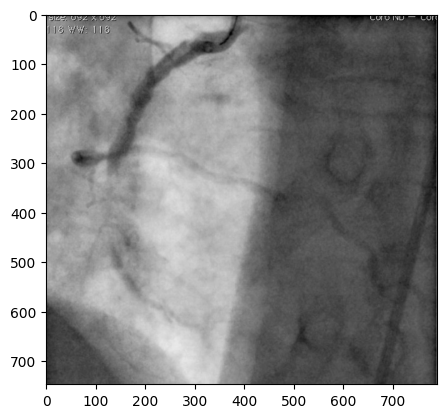

In [5]:
devices = jax.devices()
for device in devices:
    print(f"Device {device.id}: {device.device_kind}, {device.platform}")

import os
import json

img_dir = '../Experiments/test/'

query = 'lung'
# classes = ['brain', 'abdomen', 'breast']
# classes = ['mammography', 'CT', 'X-ray', 'ultrasound']
classes = ['man', 'woman']
# classes = ['malignancy', 'cancer', 'air']

img_path = os.listdir(img_dir)[0]
# img_path = "ROCO_00001.jpg"
caption = "Axial MRI (coronal view)."
# inputs = processor(text=[query], images=None, return_tensors="jax", padding=True)
# query_vec = model.get_text_features(**inputs)
print(img_path)
# Let's load a sample image
import os
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open(os.path.join(img_dir, img_path)).convert('RGB')
plt.imshow(img, aspect='equal', cmap='gray')
sentences = [f'{c} with' for c in classes]
print(sentences)
inputs = processor(images=img, return_tensors="jax", padding=True)
inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
img_vec = model.get_image_features(**inputs)
img_vec = np.array(img_vec).reshape(-1)
# img_vec_s = ",".join(["{:.7e}".format(x) for x in img_vec])
print(img_vec)

In [11]:
# processor = CLIPProcessor.from_pretrained(vision_model_name)
# sentences = [f'showing {c} in' for c in classes]
organs = ['breast', 'lung']
class_text = [f'{c} scan' for c in classes]
sentences = [f'{organ} {t}' for organ in organs for t in class_text]
print(sentences)

# max_seq_length = 128
# pixel_values = torch.stack([example[0] for example in examples]).permute(0, 2, 3, 1).numpy()
# pixel_values = torch.stack([example[0] for example in examples]).numpy()
# inputs = tokenizer(sentences, max_length=max_seq_length, padding="max_length", return_tensors="np",
#                     truncation=True)
# batch = {
#         "pixel_values": pixel_values,
#         "input_ids": inputs["input_ids"],
#         "attention_mask": inputs["attention_mask"],
#     }
inputs = processor(text=sentences, images=img, return_tensors="jax", padding=True)
max_length=128
# inputs = processor(text=sentences, images=img, return_tensors="jax", padding="max_length", max_length=max_length)
query_vec = model.get_text_features(**inputs)
print(f'query_vec={query_vec}')
# inputs = processor(text=sentences, images=img, return_tensors="jax", padding=True)
print(inputs['pixel_values'].shape)
inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
print(inputs['pixel_values'].shape)
print(inputs.keys())
print(inputs['input_ids'].shape)
print(inputs['input_ids'])
# # print(inputs['attention_mask'])
# import pickle
# # Save the list to a file
# with open('input_ids_bad.pkl', 'wb') as f:
#     pickle.dump(inputs['input_ids'], f)

['breast man scan', 'breast woman scan', 'lung man scan', 'lung woman scan']


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:21                                                                                   │
│                                                                                                  │
│   18 inputs = processor(text=sentences, images=img, return_tensors="jax", padding=True)          │
│   19 max_length=128                                                                              │
│   20 # inputs = processor(text=sentences, images=img, return_tensors="jax", padding="max_leng    │
│ ❱ 21 query_vec = model.get_text_features(**inputs)                                               │
│   22 print(f'query_vec={query_vec}')                                                             │
│   23 # inputs = processor(text=sentences, images=img, return_tensors="jax", padding=True)        │
│   24 print(inputs['pixel_values'].shape)                                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: FlaxHybridCLIP.get_text_features() got an unexpected keyword argument 'pixel_values'

In [8]:
# Load the list from the file
import pickle
with open('input_ids_bad.pkl', 'rb') as f:
    input_ids = pickle.load(f)
print(type(input_ids))
print(input_ids)

<class 'jaxlib.xla_extension.ArrayImpl'>
[[49406  9475   786 11261 49407]
 [49406  9475  2308 11261 49407]
 [49406 16271   786 11261 49407]
 [49406 16271  2308 11261 49407]]


In [9]:
from flax.linen.module import Module
from flax.linen import initializers
import dataclasses
import jax.numpy as jnp
from flax.linen.dtypes import promote_dtype
from typing import (Any, Callable, Iterable, List, Optional, Sequence, Tuple,
                    Union)
PRNGKey = Any
Shape = Tuple[int, ...]
Dtype = Any  # this could be a real type?
Array = Any

default_embed_init = initializers.variance_scaling(1.0, 'fan_in', 'normal', out_axis=0)
class Embed(Module):
  """Embedding Module.

  A parameterized function from integers [0, n) to d-dimensional vectors.

  Attributes:
    num_embeddings: number of embeddings.
    features: number of feature dimensions for each embedding.
    dtype: the dtype of the embedding vectors (default: same as embedding).
    param_dtype: the dtype passed to parameter initializers (default: float32).
    embedding_init: embedding initializer.
  """
  num_embeddings: int
  features: int
  dtype: Optional[Dtype] = None
  param_dtype: Dtype = jnp.float32
  embedding_init: Callable[[PRNGKey, Shape, Dtype], Array] = default_embed_init

  embedding: Array = dataclasses.field(init=False)

  def setup(self):
    self.embedding = self.param('embedding',
                                self.embedding_init,
                                (self.num_embeddings, self.features),
                                self.param_dtype)

  def __call__(self, inputs: Array) -> Array:
    """Embeds the inputs along the last dimension.

    Args:
      inputs: input data, all dimensions are considered batch dimensions.

    Returns:
      Output which is embedded input data.  The output shape follows the input,
      with an additional `features` dimension appended.
    """
    if not jnp.issubdtype(inputs.dtype, jnp.integer):
      raise ValueError('Input type must be an integer or unsigned integer.')
    # Use take because fancy indexing numpy arrays with JAX indices does not
    # work correctly.
    embedding, = promote_dtype(self.embedding, dtype=self.dtype, inexact=False)
    return jnp.take(embedding, inputs, axis=0)

  def attend(self, query: Array) -> Array:
    """Attend over the embedding using a query array.

    Args:
      query: array with last dimension equal the feature depth `features` of the
        embedding.
    Returns:
      An array with final dim `num_embeddings` corresponding to the batched
      inner-product of the array of query vectors against each embedding.
      Commonly used for weight-sharing between embeddings and logit transform
      in NLP models.
    """
    query, embedding = promote_dtype(query, self.embedding, dtype=self.dtype)
    return jnp.dot(query, embedding.T)

In [10]:
import flax.linen as nn
import jax.numpy as jnp
import jax
vocab_size=31090
hidden_size=768
initializer_range=0.02
word_embeddings = Embed(
            vocab_size,
            hidden_size,
            embedding_init=jax.nn.initializers.normal(stddev=initializer_range),
            dtype=jnp.float32,
        )
print(word_embeddings)
inputs_embeds = word_embeddings(input_ids.astype("i4"))

Embed(
    # attributes
    num_embeddings = 31090
    features = 768
    dtype = float32
    param_dtype = float32
    embedding_init = init
)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:14                                                                                   │
│                                                                                                  │
│   11 │   │   │   dtype=jnp.float32,                                                              │
│   12 │   │   )                                                                                   │
│   13 print(word_embeddings)                                                                      │
│ ❱ 14 inputs_embeds = word_embeddings(input_ids.astype("i4"))                                     │
│   15                                                                                             │
│                                                                                                  │
│ /home/yzhou/miniconda3/envs/medclip/lib/python3.10/site-packages/flax/linen/module.py:432 in     │
│ wrapped_module_method                                                                            │
│                                                                                                  │
│    429 │   # otherwise call the wrapped function as is.                                          │
│    430 │   if args and isinstance(args[0], Module):                                              │
│    431 │     self, args = args[0], args[1:]                                                      │
│ ❱  432 │     return self._call_wrapped_method(fun, args, kwargs)                                 │
│    433 │   else:                                                                                 │
│    434 │     return fun(*args, **kwargs)                                                         │
│    435   wrapped_module_method.method_handler_wrapped = True  # type: ignore[attr-defined]       │
│                                                                                                  │
│ /home/yzhou/miniconda3/envs/medclip/lib/python3.10/site-packages/flax/linen/module.py:868 in     │
│ _call_wrapped_method                                                                             │
│                                                                                                  │
│    865 │     # call method                                                                       │
│    866 │     if _use_named_call:                                                                 │
│    867 │   │   with jax.named_scope(_derive_profiling_name(self, fun)):                          │
│ ❱  868 │   │     y = fun(self, *args, **kwargs)                                                  │
│    869 │     else:                                                                               │
│    870 │   │   y = fun(self, *args, **kwargs)                                                    │
│    871                                                                                           │
│                                                                                                  │
│ in __call__:54                                                                                   │
│                                                                                                  │
│   51 │     raise ValueError('Input type must be an integer or unsigned integer.')                │
│   52 │   # Use take because fancy indexing numpy arrays with JAX indices does not                │
│   53 │   # work correctly.                                                                       │
│ ❱ 54 │   embedding, = promote_dtype(self.embedding, dtype=self.dtype, inexact=False)             │
│   55 │   return jnp.take(embedding, inputs, axis=0)                                              │
│   56                                                                                             │
│   57   def attend(self, query: Array) -> Array:            

In [8]:
outputs = model(**inputs)
print(outputs.logits_per_image.shape)
# outputs

text_module = <class 'transformers.models.bert.modeling_flax_bert.FlaxBertModule'>
self.logit_scale in setup = 1.1164790391921997
TODO: embedding.shape = (50, 768)
TODO: embedding = [[ 0.00032942 -0.00018357 -0.0001864  ... -0.00100739  0.00169834
  -0.00017751]
 [-0.00099671 -0.00809964 -0.00064721 ...  0.00708622  0.00703227
   0.01037503]
 [ 0.00059166 -0.01127333  0.00715961 ...  0.00276759  0.02541587
  -0.02872863]
 ...
 [-0.00388875  0.00615463  0.00446423 ...  0.00178836  0.01928777
  -0.01686388]
 [ 0.00395448 -0.002493    0.00259616 ...  0.00035157 -0.01550924
   0.01401745]
 [ 0.01355119  0.0007366  -0.00157394 ... -0.00894118  0.00299247
  -0.01602719]]
TODO: inputs = [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 49]]
TODO: temp = [[[ 0.00032942 -0.00018357 -0.0001864  ... -0.00100739  0.00169834
   -0.00017751]
  [-0.00099671 -0.00809964 -0.00064721 ...  0.00708622  0

In [21]:
outputs.logits_per_image.shape
outputs

FlaxCLIPOutput(logits_per_image=Array([[-0.09730929, -0.33259112, -0.3435168 , -0.22277613]], dtype=float32), logits_per_text=Array([[-0.09730929],
       [-0.33259112],
       [-0.3435168 ],
       [-0.22277613]], dtype=float32), text_embeds=Array([[-0.04301362, -0.01196294, -0.0335089 , ..., -0.00178267,
         0.08853503, -0.09629273],
       [-0.01951687,  0.01362286,  0.00143771, ...,  0.01275974,
         0.03880923, -0.05906659],
       [-0.08391271, -0.08352026, -0.01316953, ..., -0.03660727,
         0.06732195, -0.04075412],
       [-0.03945412, -0.01419236, -0.03700224, ..., -0.00742388,
         0.08880359, -0.10136661]], dtype=float32), image_embeds=Array([[ 4.33322741e-03,  1.00831147e-02,  7.13292323e-03,
         1.42559316e-02, -5.79362595e-03, -9.66040194e-02,
         8.88383985e-02, -1.03272721e-02,  2.33250242e-02,
        -4.76091914e-02, -5.82611375e-02,  5.81295267e-02,
         5.81024475e-02,  2.61548813e-02,  1.50088351e-02,
         1.28859663e-02, -6.8270

In [9]:
import jax.numpy as jnp
import pickle
with open('../Experiments/embedding.pkl', 'rb') as f:
    embedding = pickle.load(f)
with open('../Experiments/inputs.pkl', 'rb') as f:
    inputs = pickle.load(f)


temp = jnp.take(embedding, inputs, axis=0)
print(f'embedding.shape = {embedding.shape}')
print(f'inputs = {inputs}')
print(f'temp = {temp}')

embedding.shape = (2, 768)
inputs = [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
temp = [[[-5.6144560e-04 -5.9990247e-04 -1.7611735e-04 ... -3.3889860e-03
   -4.4961769e-05 -9.9646032e-04]
  [-5.6144560e-04 -5.9990247e-04 -1.7611735e-04 ... -3.3889860e-03
   -4.4961769e-05 -9.9646032e-04]
  [-5.6144560e-04 -5.9990247e-04 -1.7611735e-04 ... -3.3889860e-03
   -4.4961769e-05 -9.9646032e-04]
  [-5.6144560e-04 -5.9990247e-04 -1.7611735e-04 ... -3.3889860e-03
   -4.4961769e-05 -9.9646032e-04]
  [-5.6144560e-04 -5.9990247e-04 -1.7611735e-04 ... -3.3889860e-03
   -4.4961769e-05 -9.9646032e-04]]

 [[-5.6144560e-04 -5.9990247e-04 -1.7611735e-04 ... -3.3889860e-03
   -4.4961769e-05 -9.9646032e-04]
  [-5.6144560e-04 -5.9990247e-04 -1.7611735e-04 ... -3.3889860e-03
   -4.4961769e-05 -9.9646032e-04]
  [-5.6144560e-04 -5.9990247e-04 -1.7611735e-04 ... -3.3889860e-03
   -4.4961769e-05 -9.9646032e-04]
  [-5.6144560e-04 -5.9990247e-04 -1.7611735e-04 ... -3.3889860e-03
   -4.4961769e-05 -9.964603

In [20]:
probs = jax.nn.softmax(outputs.logits_per_image, axis=-1)

for c_name, prob in zip(sentences, probs[0]):
    print(f'{c_name}: {prob:.2f}')

breast man scan: 0.29
breast woman scan: 0.23
lung man scan: 0.23
lung woman scan: 0.26


In [10]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
img_transforms = Transform(image_size=224)
pixel_values = img_transforms(torchvision.transforms.functional.pil_to_tensor(img)).numpy()
print(pixel_values.shape)
pixel_values = pixel_values.transpose((1, 2, 0))
print(pixel_values.shape)
pixel_values = pixel_values[np.newaxis, ...]
print(pixel_values.shape)
print(f'sentences={sentences}')
# input_toks = tokenizer(sentences, max_length=128, padding="max_length", return_tensors="np",
#                     truncation=True)
input_toks = tokenizer(sentences, return_tensors="jax",
                    truncation=True)
inputs = {'pixel_values': pixel_values, 'input_ids': input_toks['input_ids']}
# outputs = model(**inputs)
print(inputs.keys())
print(inputs['input_ids'].shape)
print(inputs['input_ids'])
import pickle
# Save the list to a file
with open('input_ids_good.pkl', 'wb') as f:
    pickle.dump(inputs['input_ids'], f)

(3, 224, 224)
(224, 224, 3)
(1, 224, 224, 3)
sentences=['breast man scan', 'breast woman scan', 'lung man scan', 'lung woman scan']
dict_keys(['pixel_values', 'input_ids'])
(4, 6)
[[    0  7805  1988   313 14194     2]
 [    0  7805  1988   693 14194     2]
 [    0   462  1545   313 14194     2]
 [    0   462  1545   693 14194     2]]


In [11]:
# Load the list from the file
with open('input_ids_good.pkl', 'rb') as f:
    loaded_list = pickle.load(f)
print(type(loaded_list))
print(loaded_list)

<class 'jaxlib.xla_extension.ArrayImpl'>
[[    0  7805  1988   313 14194     2]
 [    0  7805  1988   693 14194     2]
 [    0   462  1545   313 14194     2]
 [    0   462  1545   693 14194     2]]


In [13]:
print(input_toks['input_ids'])
outputs = model(**inputs)
print(outputs)

[[    0  7805  1988   313 14194     2]
 [    0  7805  1988   693 14194     2]
 [    0   462  1545   313 14194     2]
 [    0   462  1545   693 14194     2]]
text_module = <class 'transformers.models.bert.modeling_flax_bert.FlaxBertModule'>
self.logit_scale in setup = 1.1164790391921997
TODO: embedding.shape = (50, 768)
TODO: embedding = [[ 0.00032942 -0.00018357 -0.0001864  ... -0.00100739  0.00169834
  -0.00017751]
 [-0.00099671 -0.00809964 -0.00064721 ...  0.00708622  0.00703227
   0.01037503]
 [ 0.00059166 -0.01127333  0.00715961 ...  0.00276759  0.02541587
  -0.02872863]
 ...
 [-0.00388875  0.00615463  0.00446423 ...  0.00178836  0.01928777
  -0.01686388]
 [ 0.00395448 -0.002493    0.00259616 ...  0.00035157 -0.01550924
   0.01401745]
 [ 0.01355119  0.0007366  -0.00157394 ... -0.00894118  0.00299247
  -0.01602719]]
TODO: inputs = [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 4

In [22]:
img_dir = '../Experiments/test/'

query = 'carcinoma'
img_list = os.listdir(img_dir)[:10]
imgs = [Image.open(os.path.join(img_dir, img_path)).convert('RGB') for img_path in img_list]
inputs = processor(text=[query], images=imgs, return_tensors="jax", padding=True)
inputs['pixel_values'] = inputs['pixel_values'] #.transpose(0, 2, 3, 1)
outputs = model(**inputs)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:8                                                                                    │
│                                                                                                  │
│   5 imgs = [Image.open(os.path.join(img_dir, img_path)).convert('RGB') for img_path in img_l     │
│   6 inputs = processor(text=[query], images=imgs, return_tensors="jax", padding=True)            │
│   7 inputs['pixel_values'] = inputs['pixel_values'] #.transpose(0, 2, 3, 1)                      │
│ ❱ 8 outputs = model(**inputs)                                                                    │
│   9                                                                                              │
│                                                                                                  │
│ /home/yzhou/Development/medclip/tools/../medclip/modeling_hybrid_clip.py:192 in __call__         │
│                                                                                                  │
│   189 │   │   if dropout_rng is not None:                                                        │
│   190 │   │   │   rngs["dropout"] = dropout_rng                                                  │
│   191 │   │                                                                                      │
│ ❱ 192 │   │   return self.module.apply(                                                          │
│   193 │   │   │   {"params": params or self.params},                                             │
│   194 │   │   │   jnp.array(input_ids, dtype="i4"),                                              │
│   195 │   │   │   jnp.array(pixel_values, dtype=jnp.float32),                                    │
│                                                                                                  │
│ /home/yzhou/miniconda3/envs/medclip/lib/python3.10/site-packages/jax/_src/traceback_util.py:166  │
│ in reraise_with_filtered_traceback                                                               │
│                                                                                                  │
│   163   def reraise_with_filtered_traceback(*args, **kwargs):                                    │
│   164 │   __tracebackhide__ = True                                                               │
│   165 │   try:                                                                                   │
│ ❱ 166 │     return fun(*args, **kwargs)                                                          │
│   167 │   except Exception as e:                                                                 │
│   168 │     mode = _filtering_mode()                                                             │
│   169 │     if _is_under_reraiser(e) or mode == "off":                                           │
│                                                                                                  │
│ /home/yzhou/miniconda3/envs/medclip/lib/python3.10/site-packages/flax/linen/module.py:1538 in    │
│ apply                                                                                            │
│                                                                                                  │
│   1535 │   elif method is None:                                                                  │
│   1536 │     method = self.__call__                                                              │
│   1537 │   method = _get_unbound_fn(method)                                                      │
│ ❱ 1538 │   return apply(                                                                         │
│   1539 │   │   method, self,                                                                     │
│   1540 │   │   mutable=mutable,                                                                  │
│   1541 │   │   capture_intermediates=capture_intermediates,

In [21]:
probs = jax.nn.softmax(outputs.logits_per_text, axis=-1)

for img_name, prob in zip(img_list, probs[0]):
    print(f'{img_name}: {prob:.2f}')

ROCO_00031.jpg: nan
ROCO_00006.jpg: nan
ROCO_00138.jpg: nan
ROCO_00061.jpg: nan
ROCO_00016.jpg: nan
ROCO_00153.jpg: nan
ROCO_00001.jpg: nan
ROCO_00036.jpg: nan
ROCO_00025.jpg: nan
ROCO_00084.jpg: nan


In [213]:
# Encode a bunch of images using the model
embeddings = []
query = 'abdomen'
image_vec_file = './demo/image_embeddings.tsv'

fvec = open(image_vec_file, "w")
img_list = os.listdir(img_dir)[:20]

for idx, img_path in enumerate(img_list):
    if idx % 20 == 0:
        print(f"{idx} images processed")
    img = Image.open(os.path.join(img_dir, img_path)).convert('RGB')
    inputs = processor(images=img, return_tensors="jax", padding=True)
    inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
    img_vec = model.get_image_features(**inputs)
    img_vec = np.array(img_vec).reshape(-1)
    img_vec_s = ",".join(["{:.7e}".format(x) for x in img_vec])
    embeddings.append(np.array(img_vec).reshape(-1))
    fvec.write(f"{img_path}\t{img_vec_s}\n")

fvec.close()


0 images processed


In [212]:
import nmslib
def load_index(embedding_file):
    filenames, image_vecs = [], []
    with open(embedding_file, "r") as fvec:
        for line in fvec:
            cols = line.strip().split('\t')
            filename = cols[0]
            image_vec = np.array([float(x) for x in cols[1].split(',')])
            filenames.append(filename)
            image_vecs.append(image_vec)
    V = np.array(image_vecs)
    index = nmslib.init(method='hnsw', space='cosinesimil')
    index.addDataPointBatch(V)
    index.createIndex({'post': 2}, print_progress=True)
    return filenames, index

In [37]:
max_seq_length = 128
pixel_values = torch.stack([example[0] for example in examples]).permute(0, 2, 3, 1).numpy()
# pixel_values = torch.stack([example[0] for example in examples]).numpy()
captions = [example[1] for example in examples]
inputs = tokenizer(captions, max_length=max_seq_length, padding="max_length", return_tensors="np",
                    truncation=True)
batch = {
        "pixel_values": pixel_values,
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
    }
logits = model(**batch, train=False)[0]

torch.Size([3, 224, 224])